<a href="https://colab.research.google.com/github/WahajSayyed/Machine-Learning-Projects/blob/main/Tensorflow_Convolutions_with_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tensorflow Convolutions with Transfer Learning

https://github.com/https-deeplearning-ai/tensorflow-1-public/blob/main/C2/W3/ungraded_lab/C2_W3_Lab_1_transfer_learning.ipynb

Use a pre-trained model to achieve good results even with a small training dataset.



1.   just get the convolution layers of one model
2.   attach some dense layers onto it
3.   train just the dense network
4.   evaluate the results


In [ ]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5b

--2024-01-18 18:02:55--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.207, 74.125.31.207, 74.125.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5b’

/tmp/inception_v3_w 100%[===================>]  83.84M   147MB/s    in 0.6s    

2024-01-18 18:02:55 (147 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5b’ saved [87910968/87910968]



In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

local_wieghts_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5b'

# "include_top = False" means we are not using Dense layer of InceptionV3 (We'll train our own dense layers)
pre_trained_model = InceptionV3(input_shape=(150,150,3),
                                include_top=False,
                                weights=None)

#Loading already trained weights which we dowloaded earlier
pre_trained_model.load_weights(local_wieghts_file)

# Freezing/locking the weight of the layer (bit similar to LLM finetuning)
for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 74, 74, 32)           864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 74, 74, 32)           96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 74, 74, 32)           0         ['batch_normalizati

In [ ]:
# Choosing `mixed7` as the last layer of base model

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output


last layer output shape:  (None, 7, 7, 768)


#Adding Dense layer (with Dropour) for our classifier

In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

#Append the Dense network to the base model
model = Model(pre_trained_model.input, x)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 74, 74, 32)           864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 74, 74, 32)           96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 74, 74, 32)           0         ['batch_normalization_94[0

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

#Prepare the dataset
Now you will prepare the dataset. Cat vs Dog dataset.
This is basically the same code as the one you used in the data augmentation lab.

In [ ]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2024-01-18 18:32:04--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.11.207, 108.177.13.207, 74.125.26.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.11.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip.1’

cats_and_dogs_filte 100%[===================>]  65.43M   132MB/s    in 0.5s    

2024-01-18 18:32:05 (132 MB/s) - ‘cats_and_dogs_filtered.zip.1’ saved [68606236/68606236]



In [ ]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

zip_ref = zipfile.ZipFile('cats_and_dogs_filtered.zip', 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

base_dir = os.path.join('tmp/cats_and_dogs_filtered')

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_datagenerator = ImageDataGenerator(rescale=1./255,
                                         rotation_range=40,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         shear_range=0.2,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         )

test_dataenerator = ImageDataGenerator(rescale=1./255)

train_generator = train_datagenerator.flow_from_directory(train_dir,
                                                          batch_size=20,
                                                          target_size=(150,150),
                                                          class_mode='binary')
test_generator = test_dataenerator.flow_from_directory(validation_dir,
                                                       batch_size=20,
                                                       target_size=(150,150),
                                                       class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
os.listdir('tmp/cats_and_dogs_filtered')

['validation', 'train', 'vectorize.py']

#Train the model
With that, we can now train the model. We will do 20 epochs and plot the results afterwards

In [ ]:
history = model.fit(train_generator,
                    validation_data=test_generator,
                    epochs=20,
                    steps_per_epoch=100,
                    validation_steps=50,
                    verbose=1)

Epoch 1/20
100/100 [==============================] - 274s 3s/step - loss: 0.3667 - accuracy: 0.8640 - val_loss: 0.1292 - val_accuracy: 0.9450
Epoch 2/20
100/100 [==============================] - 280s 3s/step - loss: 0.2144 - accuracy: 0.9185 - val_loss: 0.1985 - val_accuracy: 0.9320
Epoch 3/20
100/100 [==============================] - 255s 3s/step - loss: 0.1974 - accuracy: 0.9245 - val_loss: 0.1251 - val_accuracy: 0.9600
Epoch 4/20
100/100 [==============================] - 243s 2s/step - loss: 0.1709 - accuracy: 0.9325 - val_loss: 0.1065 - val_accuracy: 0.9580
Epoch 5/20
100/100 [==============================] - 203s 2s/step - loss: 0.1689 - accuracy: 0.9340 - val_loss: 0.0967 - val_accuracy: 0.9650
Epoch 6/20
100/100 [==============================] - 238s 2s/step - loss: 0.1583 - accuracy: 0.9425 - val_loss: 0.1442 - val_accuracy: 0.9500
Epoch 7/20
100/100 [==============================] - 249s 2s/step - loss: 0.1246 - accuracy: 0.9515 - val_loss: 0.1439 - val_accuracy: 0.9510

#Evaluate the results
We will use the same code to plot the results. As we can see, the validation accuracy is also trending upwards as your training accuracy improves. This is a good sign that our model is no longer overfitting!



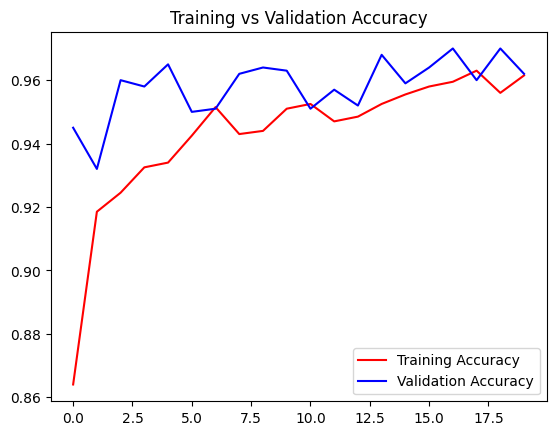

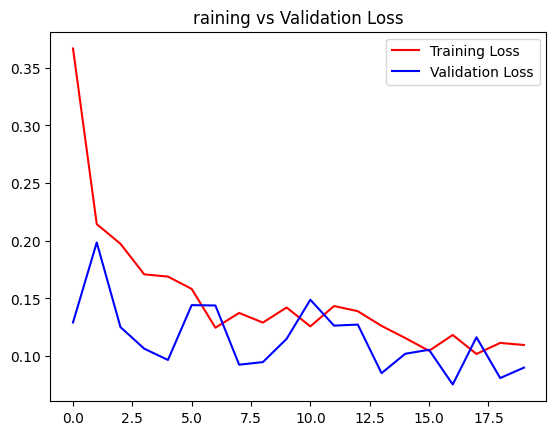

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend(loc=0)

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('raining vs Validation Loss')
plt.legend()



plt.show()